# Restauration d'image à l'aide de l'ADMM

## I/ Altération d'une image

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import cg
import time

### Manipulation 1

In [2]:
data = pickle.load(open('data.pk','rb'),encoding='latin1')
H = data.get('H').toarray()
original = data.get('original')
observations = data.get('observations')
x_original = np.reshape(original, (64**2,1))
y = np.reshape(observations, (64**2,1))

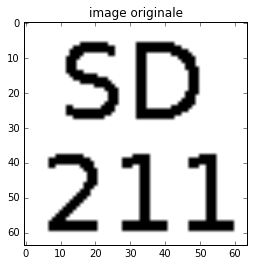

In [3]:
plt.imshow(original, cmap='gray')
plt.title('image originale')
plt.show()

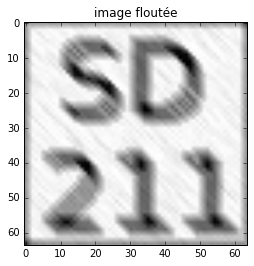

In [4]:
plt.imshow(observations, cmap='gray')
plt.title('image floutée')
plt.show()

## II/ Restauration d'image

### Préparation 1

On veut minimiser $ \frac{1}{2}||y-Hx||_{2}^2 +\beta ||Tx||_{1} +i_{[0,1]^p}(x)$ avec $\iota_{I}(x)=
 +\infty$ si $x\not\in I$
et $0$ si $x\in I$

En posant $z_1=x$ et $z_2=Tx$ alors nous devons minimiser $ \frac{1}{2}||y-Hx||_{2}^2 +\beta ||z_2||_{1} +\iota_{[0,1]^p}(z_1)$ c'est à dire $f(x)+g(z)$ avec $f(x)=\frac{1}{2}||y-Hx||_{2}^2$ et $g(z)=g([z_1^T,z_2^T]^T) = \beta ||z_2||_{1} +\iota_{[0,1]^p}(z_1)$ sous la contrainte $Ax=z$ avec $A=\begin{bmatrix}
I_p \\
T
\end{bmatrix}$ et $z =\begin{bmatrix}
x \\
Tx
\end{bmatrix}$

### Préparation 2

$\mathcal{L}_p(x,z,\gamma) = \frac{1}{2}||y-Hx||_{2}^2 +\beta ||z_2||_{1} +\iota_{[0,1]^p}(z_1) + \gamma^T(Ax-z)+\frac{\rho}{2}||Ax-z||_2^2$

### Préparation 3

$argmin_x \mathcal{L}_p(x,z^k,\gamma^k) = argmin_x \frac{1}{2}||y-Hx||_{2}^2 + (\gamma^k)^T Ax+\frac{\rho}{2}||Ax-z^k||_2^2 $

soit $h(x) = \frac{1}{2}||y-Hx||_{2}^2 + (\gamma^k)^T Ax+\frac{\rho}{2}||Ax-z^k||_2^2$

$\nabla h(x)=-H^T(y-Hx)+A^T\gamma^k +\rho A^T(Ax-z^k)$

$\nabla h(x)=0 \Leftrightarrow (H^TH+\rho A^TA)x=H^Ty-A^T\gamma^k+\rho A^Tz^k$, or $A^TA=T^TT+I_p$

$\Leftrightarrow x = (H^TH+\rho T^TT+\rho I_p)^{-1}(H^Ty -A^T(\gamma^k-\rho z^k))$

Or $x^{k+1}=argmin_x \mathcal{L}_p(x,z^k,\gamma^k)$ donc $x^{k+1}= (H^TH+\rho A^TA)^{-1}(H^Ty -A^T(\gamma^k-\rho z^k))$

### Préparation 4

$z^{k+1} =argmin_{(z_1,z_2)} \beta ||z_2||_1 +\iota_{[0,1]^p}(z_1)-\gamma^T z +\frac{\rho}{2} ||Ax^{k+1}-z||_2^2$

$Ax^{k+1}-z= \begin{bmatrix}
x^{k+1}-z_1 \\
Tx^{k+1}-z_2
\end{bmatrix}$ donc $ ||Ax^{k+1}-z||_2^2 = ||x^{k+1}-z_1||_2^2 + ||Tx^{k+1}-z_2||_2^2$

Le problème est ainsi séparable :

$z_1^{k+1}=argmin_{z_1} \iota_{[0,1]^p}(z_1) - \gamma_1^T z_1 +\frac{\rho}{2}||x^{k+1}-z_1||_2^2$

$z_2^{k+1}=argmin_{z_2} \beta ||z_2||_1 -\gamma_2^T z_2+\frac{\rho}{2}||Tx^{k+1}-z_2||_2^2$

Si on note $z_2=[z_{2,1},z_{2,2},\cdots,z_{2,n}]^T$ et $\gamma_2=[\gamma_{2,1},\gamma_{2,2},\cdots,\gamma_{2,n}]^T $alors

$ \beta ||z_2||_1 -\gamma_2^T z_2+\frac{\rho}{2}||Tx^{k+1}-z_2||_2^2 = \beta\sum_{i=1}^n |z_{2,i}| - \sum_{i=1}^n\gamma_{2,i}z_{2,i} +\frac{\rho}{2}\sum_{i=1}^n ((Tx^{k+1})_i-z_{2,i})^2$
$=\sum_{i=1}^n \beta|z_{2,i}|-\gamma_{2,i}z_{2,i}+\frac{\rho}{2}((Tx^{k+1})_i-z_{2,i})^2$

Ainsi le problème est séparable pour chaque coordonnée, et donc:

$\forall i\in\{1,\cdots,n\}  z_{2,i}^{k+1}= argmin_{z_{2,i}}  \beta|z_{2,i}|-\gamma_{2,i}z_{2,i}+\frac{\rho}{2}((Tx^{k+1})_i-z_{2,i})^2$

De même, en notant $z_1=[z_{1,1},z_{1,2},\cdots,z_{1,n}]^T$ et $\gamma_1=[\gamma_{1,1},\gamma_{1,2},\cdots,\gamma_{1,n}]^T $alors

$\iota_{[0,1]^p}(z_1) - \gamma_1^T z_1 +\frac{\rho}{2}||x^{k+1}-z_1||_2^2 = \sum_{i=1}^n \iota_{[0,1]}(z_{1,i}) - \gamma_{1,i}z_{1,i}+\frac{\rho}{2}((x^{k+1})_i-z_{1,i})^2$ ainsi le problème est séparable pour

chaque coordonnées et $ \forall i\in\{1,\cdots,n\} z_{1,i}^{k+1}= argmin_{z_{1,i}} \iota_{[0,1]}(z_{1,i}) - \gamma_{1,i}z_{1,i}+\frac{\rho}{2}((x^{k+1})_i-z_{1,i})^2$


Déterminons $ z_{2,i}^{k+1}$. Soit $h_2(z) = \beta|z| -\gamma_{2,i} z +\frac{\rho}{2}((Tx^{k+1})_i-z)^2$

Si $z\geq 0$ alors $ h_2'(z)=(\beta - \gamma_{2,i})-\rho((Tx^{k+1})_i-z) = \rho z -\rho (Tx^{k+1})_i+\beta-\gamma_{2,i}$.

Si $-\rho (Tx^{k+1})_i+\beta-\gamma_{2,i}<0\Leftrightarrow \beta<\gamma_{2,i}+\rho(Tx^{k+1})_i$ alors le minimum de $h_2$ sur $z\geq 0$ est atteint pour $z=(Tx^{k+1})_i +\frac{\gamma_{2,i}-\beta}{\rho}$, sinon le minimum est atteint pour $z=0$.

Si $z<0$ alors $h_2'(z)=(-\beta - \gamma_{2,i})-\rho((Tx^{k+1})_i-z) = \rho z -\rho (Tx^{k+1})_i-\beta-\gamma_{2,i}$.

Si $-\rho (Tx^{k+1})_i-\beta-\gamma_{2,i}>0\Leftrightarrow \beta<-\gamma_{2,i}-\rho(Tx^{k+1})_i$ alors le minimum de $h_2$ sur $z<0$ est atteint pour $z=(Tx^{k+1})_i +\frac{\gamma_{2,i}+\beta}{\rho}$, sinon le minimum est atteint pour $z=0$.

Comme $\beta\geq 0$ alors on compare $\beta$ à $|\gamma_{2,i}+\rho(Tx^{k+1})_i|$

Si $\beta<|\gamma_{2,i}+\rho(Tx^{k+1})_i|\Leftrightarrow 1-\frac{\beta}{|\gamma_{2,i}+\rho(Tx^{k+1})_i|}>0$ alors $z= (Tx^{k+1})_i+\frac{\gamma_{2,i}}{\rho}-\frac{\beta}{\rho}(\frac{Tx^{k+1})_i+\frac{\gamma_{2,i}}{\rho}}{|Tx^{k+1})_i+\frac{\gamma_{2,i}}{\rho}|}) = (Tx^{k+1})_i+\frac{\gamma_{2,i}}{\rho}(1-\frac{\beta}{|\gamma_{2,i}+\rho(Tx^{k+1})_i|})$, sinon $z=0$, donc $z=(Tx^{k+1})_i+\frac{\gamma_{2,i}}{\rho}\max(0,1-\frac{\beta}{|\gamma_{2,i}+\rho(Tx^{k+1})_i|})$

Donc $z_{2,i}^{k+1}= (Tx^{k+1})_i+\frac{\gamma_{2,i}}{\rho}\max(0,1-\frac{\beta}{|\gamma_{2,i}+\rho(Tx^{k+1})_i|})$

Déterminons $ z_{1,i}^{k+1}$. Soit $h_1(z)=\iota_{[0,1]}(z)+\frac{\rho}{2}(z-(x^{k+1})_i+\frac{\gamma_{1,i}}{\rho})^2$

Si $(x^{k+1})_i+\frac{\gamma_{1,i}}{\rho}\in [0,1]$ alors $h_1$ atteint son minimum pour $z=(x^{k+1})_i+\frac{\gamma_{1,i}}{\rho}$
Si $(x^{k+1})_i+\frac{\gamma_{1,i}}{\rho}>1$ alors $h_1$ atteint sont minimum pour $z=1$
Si $(x^{k+1})_i+\frac{\gamma_{1,i}}{\rho}<0$ alors $h_1$ atteint sont minimum pour $z=0$

Donc $z_{1,i}^{k+1}=\min(1,max(0,(x^{k+1})_i+\frac{\gamma_{1,i}}{\rho}))$

### Préparation 5

$\gamma^{k+1}=\gamma^{k}+\rho(Ax^{k+1}-z^{k+1})$ donc $\gamma^{k+1}=\begin{bmatrix}
\gamma_1^{k+1} \\
\gamma_2^{k+1}
\end{bmatrix}
=\begin{bmatrix}
\gamma_1^{k}+\rho(x^{k+1} - z_1^{k+1}) \\
\gamma_2^{k}+\rho(Tx^{k+1} - z_2^{k+1})
\end{bmatrix}$ donc 
$\gamma_1^{k+1} = \gamma_1^{k}+\rho(x^{k+1} - z_1^{k+1})$ et $\gamma_2^{k+1} = \gamma_2^{k}+\rho(Tx^{k+1} - z_2^{k+1})$

## III/ Implémentation de l'ADMM pour résoudre le problème de res- tauration d'image

### Manipulation 2

In [5]:
rho = 0.05
beta = 0.01
k_max = 100
T = data.get('T').toarray()
A = np.concatenate((np.eye(4096),T),axis=0)

En posant

\begin{cases}
B & =\left(H^{T}H+\rho A^{T}A\right)\\
c^{k} & =H^{T}y-A^{T}\left(\gamma^{k}-\rho z^{k}\right)
\end{cases}

On obtient

\begin{array}{cc}
 & x^{k+1}=B^{-1}c^{k}\\
\Longrightarrow & Bx^{k+1}=c^{k}
\end{array}

Il s'agit d'un système linéaire, solvable avec l'algorithme du gradient conjugué

In [6]:
#ADMM
def ADMM(rho,beta,k_max):
    x = np.random.random_sample(4096)
    x = x.reshape(len(x),1)
    z1 = x
    z2 = np.dot(T,x)
    z=np.concatenate((z1,z2),axis=0)
    gamma1 = np.random.random_sample(len(z1))
    gamma1 = gamma1.reshape(len(gamma1),1)
    gamma2 = np.random.random_sample(len(z2))
    gamma2 = gamma2.reshape(len(gamma2),1)
    gamma = np.concatenate((gamma1,gamma2),axis=0)
    B = np.dot(H.T,H)+rho*(np.dot(A.T,A))
    for i in range (0,k_max):
        #mise à jour de x:
        #x = np.dot(np.linalg.inv(np.dot(H.T,H)+rho*(np.dot(A.T,A))), np.dot(H.T,y) - np.dot(A.T,gamma - rho*z))
        c = np.dot(H.T,y) - np.dot(A.T,gamma - rho*z)
        #print(B.shape, len(c))
        x,_ = cg(B,c)
        x = np.reshape(x, (len(x),1))
        #print(x.shape,z1.shape)
        #mise à jour de z1:
        for i in range(0,len(z1)):
            z1[i] = min(1,max(0,x[i]+(1/rho)*gamma1[i]))
        #mise à jour de z2:
        U = np.dot(T,x)
        for i in range(0,len(z2)):
            z2[i]= U[i] + (1/rho)*gamma2[i]*max(0,1-(beta/np.abs(gamma2[i]+rho*U[i])))
        z=np.concatenate((z1, z2),axis=0)
        #mise à jour de gamma:
        gamma1 += rho*(x - z1)
        gamma2 += rho*(np.dot(T,x) - z2)
        gamma = np.concatenate((gamma1,gamma2),axis=0) 
    return x

In [7]:
x = ADMM(rho = rho, beta = beta, k_max = k_max)
x1 = np.reshape(x,(64,64))

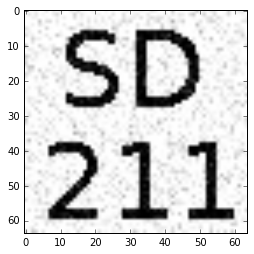

In [8]:
plt.imshow(x1, cmap='gray')
plt.show()

### Manipulation 3

In [9]:
def iota(x,a,b):
    d = len(x)
    for i in range (0,d):
        if (x[i] < a) or (x[i] > b):
            return float("inf")
    return 0

In [10]:
def lag_aug(x,z,z1,z2,gamma):
    norme_z2 = 0
    a = 0.5*(np.linalg.norm(y - np.dot(H, x)))**2 + beta*np.linalg.norm(z2, ord=1) + iota(z1,
        0,1) + np.dot(gamma.T,np.dot(A,x) - z) + (rho/2)*(np.linalg.norm(np.dot(A,x) - z))**2
    return a

In [11]:
def ADMM_stats(rho,beta,k_max):
    x = np.random.random_sample(4096)
    P = len(x)
    x = x.reshape(P,1)
    z1 = x
    z2 = np.dot(T,x)
    z=np.concatenate((z1,z2),axis=0)
    gamma1 = np.random.random_sample(len(z1))
    gamma1 = gamma1.reshape(len(gamma1),1)
    gamma2 = np.random.random_sample(len(z2))
    gamma2 = gamma2.reshape(len(gamma2),1)
    gamma = np.concatenate((gamma1,gamma2),axis=0)
    B = np.dot(H.T,H)+rho*(np.dot(A.T,A))
    lag_aug_evolution = [lag_aug(x,z,z1,z2,gamma)]
    biais = [x_original - x]
    somme_norme_carre_biais = (np.linalg.norm(biais[0]))**2
    EQM = [somme_norme_carre_biais/P]
    abcisse = [0]
    for i in range (0, k_max):
        #mise à jour de x:
        c = np.dot(H.T,y) - np.dot(A.T,gamma - rho*z)
        x,_ = cg(B,c)
        x = np.reshape(x, (len(x),1))
        #mise à jour de z1:
        for j in range(0,len(z1)):
            z1[j] = min(1,max(0,x[j]+(1/rho)*gamma1[j]))
        #mise à jour de z2:
        U = np.dot(T,x)
        for k in range(0,len(z2)):
            z2[k]= U[k] + (1/rho)*gamma2[k]*max(0,1-(beta/np.abs(gamma2[k]+rho*U[k])))
        z=np.concatenate((z1, z2),axis=0)
        #mise à jour de gamma:
        gamma1 += rho*(x - z1)
        gamma2 += rho*(np.dot(T,x) - z2)
        gamma = np.concatenate((gamma1,gamma2),axis=0)
        #actualisation de EQM et lagrangien augmenté:
        abcisse.append(i+1)
        lag_aug_evolution.append(lag_aug(x,z,z1,z2,gamma))
        biais.append(x_original - x)
        somme_norme_carre_biais += (np.linalg.norm(biais[i+1]))**2
        #EQM.append(somme_norme_carre_biais/(i+2))
        EQM.append(somme_norme_carre_biais/(i+2)/P) #Il faut diviser par le nombre de dimensions normalement, pas sur le nombre des itérations
    # mise sous forme de liste de lag_aug_evolution
    lag_aug_evolution_bis = []
    for i in range (0, len(lag_aug_evolution)):
        lag_aug_evolution_bis.append(lag_aug_evolution[i][0][0])
    return (x, biais, lag_aug_evolution_bis, EQM)

In [12]:
x, biais, lag_aug_evolution_bis, EQM = ADMM_stats(rho = rho,beta = beta,k_max = k_max)

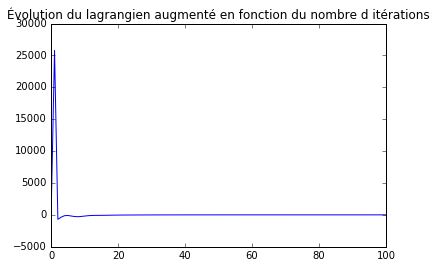

In [13]:
abcisse = range(0,k_max+1)
plt.plot(abcisse, lag_aug_evolution_bis)
plt.title ('Évolution du lagrangien augmenté en fonction du nombre d itérations')
plt.show()

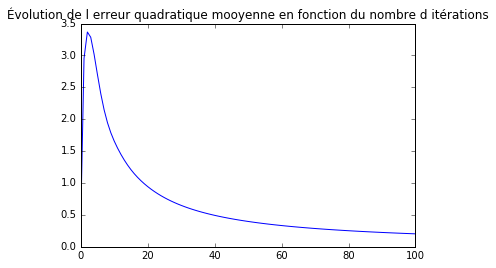

In [14]:
plt.plot(abcisse,EQM)
plt.title ('Évolution de l erreur quadratique mooyenne en fonction du nombre d itérations')
plt.show()

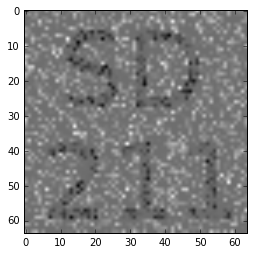

In [15]:
plt.close("all")
plt.imshow(np.reshape(biais[len(biais)-1], (64,64)) ,cmap="gray")
plt.show()

### Manipulation 4

In [26]:
Biais = []
Lag = []
eqm = []
Time = []
for r in np.arange(0.01,0.1,0.02):
    print("rho = ", r)
    start = time.clock()
    x, biais, lag_aug_evolution_bis, EQM = ADMM_stats(rho = r,beta = beta,k_max = k_max)
    Time.append(time.clock() - start)
    #print(Time[len(Time)-1])
    Biais.append(biais[len(biais)-1])
    Lag.append(lag_aug_evolution_bis[len(lag_aug_evolution_bis)-1])
    eqm.append(EQM[len(EQM)-1])

rho =  0.01
rho =  0.03
rho =  0.05
rho =  0.07
rho =  0.09


[3117.007912000001, 2810.7616110000017, 2608.2446950000012, 2650.998367, 2655.6078410000046]


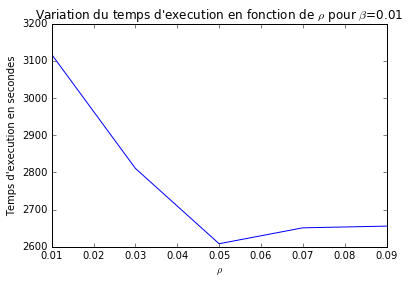

In [29]:
#Visulation de l'évolution du temps d'exécution
print(Time)
plt.close("all")
plt.plot(np.arange(0.01,0.1,0.02), np.asarray(Time))
plt.xlabel(r"$\rho$")
plt.ylabel("Temps d'execution en secondes")
plt.title(r"Variation du temps d'execution en fonction de $\rho$ pour $\beta$=0.01")
plt.show()

In [ ]:
Biais_b = []
Lag_b = []
eqm_b = []
Time_b = []
for b in np.arange(0.01,0.1,0.02):
    print("beta = ", b)
    start = time.clock()
    x, biais, lag_aug_evolution_bis, EQM = ADMM_stats(rho = rho,beta = b,k_max = k_max)
    Time_b.append(time.clock() - start)
    #print(Time[len(Time)-1])
    Biais_b.append(biais[len(biais)-1])
    Lag_b.append(lag_aug_evolution_bis[len(lag_aug_evolution_bis)-1])
    eqm_b.append(EQM[len(EQM)-1])